In [7]:
# Compute and plot the contour of the compact GP error model:
#   <(ΔI_GPR)^2> = α * G(ρ) / ΔQ + β * ΔQ^2 + γ * μ2(ρ)^2
# with α = β = γ = 1.
#
# Axes:
#   x-axis: ΔQ in [1e-2, 1e2] (log scale)
#   y-axis: ρ  in [1e-3, 1e1] (log scale)
# Contours are drawn for log10 of the value (i.e., "log-log-log" visualization).
#
# Implementation notes:
# - G(ρ) = θ3(0, e^{-ρ^2}) / θ3(0, e^{-ρ^2/2})^2
# - μ2(ρ) = ΔQ^2 * M2(ρ),  M2(ρ) = sum_m w_m m^2 with w_m ∝ exp(-0.5 ρ^2 m^2)
#   For small ρ (broad kernel), we use the continuum asymptotic M2 ≈ 1/ρ^2.
# - θ3 is evaluated robustly via modular transform:
#      θ3(0, e^{-π t}) = t^{-1/2} θ3(0, e^{-π/t})
#   to ensure fast convergence near ρ → 0 (i.e., t → 0).
#
# Charting constraints:
# - Use matplotlib only.
# - Single figure (no subplots).
# - Do not set custom colors/styles.

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [8]:
def theta3_from_a(a, tol=1e-14, nmax=100000):
    """
    Evaluate θ3(0, e^{-a}) robustly using modular transformation when needed.
    a > 0.
    θ3(0,q) = 1 + 2 * sum_{n=1}^\infty q^{n^2}, q = exp(-a).
    """
    if a <= 0:
        raise ValueError("Parameter 'a' must be positive.")
    # Map q = exp(-π t) form: here a = π t  => t = a/π
    t = a / math.pi
    if t < 1.0:
        # Use modular transformation: θ3(0, e^{-π t}) = t^{-1/2} θ3(0, e^{-π/t})
        t_inv = 1.0 / t
        q_small = math.exp(-math.pi * t_inv)
        # Fast convergence since q_small is tiny
        s = 1.0
        n = 1
        term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        return s / math.sqrt(t)
    else:
        # Direct series
        q = math.exp(-math.pi * t)
        s = 1.0
        n = 1
        term = 2.0 * q ** (n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * q ** (n * n)
        return s

def G_of_rho(rho):
    # G(ρ) = θ3(e^{-ρ^2}) / θ3(e^{-ρ^2/2})^2
    a1 = rho**2
    a2 = rho**2 / 2.0
    th1 = theta3_from_a(a1)
    th2 = theta3_from_a(a2)
    return th1 / (th2**2)

def M2_of_rho(rho):
    """
    Dimensionless second moment for discrete Gaussian weights.
    For small rho, use continuum asymptotic 1/rho^2 (accurate up to exponentially small error).
    Otherwise compute via truncated symmetric sum.
    """
    if rho < 0.05:
        return 1.0 / (rho**2)
    # Choose truncation based on width ~ 1/rho. Take 6 sigma-equivalent.
    M = max(10, int(math.ceil(8.0 / rho)))
    # Symmetric sum; m=0 contributes to Z only
    Z = 1.0
    num = 0.0
    c = -0.5 * rho**2
    for m in range(1, M+1):
        w = math.exp(c * m * m)
        Z += 2.0 * w
        num += 2.0 * (m*m) * w
    return num / Z

def mu2_of_rho(rho, dQ):
    # μ2(ρ) = ΔQ^2 * M2(ρ)
    return (dQ**2) * M2_of_rho(rho)


/tmp/ipykernel_1287670/4275911122.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


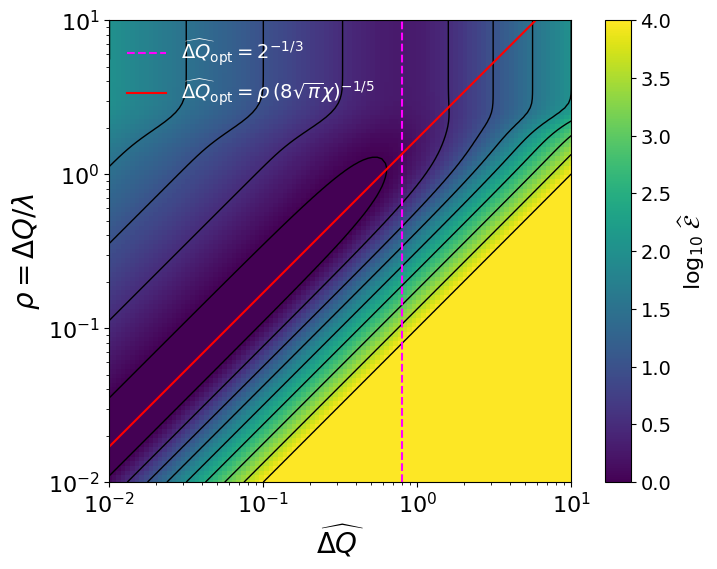

In [48]:
# ----------------------------
# Parameters and grids
# ----------------------------
dQ_vals = np.logspace(-2, 1, 101)   # \widehat{\Delta Q}
rho_vals = np.logspace(-2, 1, 101)  # \rho = \Delta Q / \lambda

# Optional: specify chi for small-ρ asymptotic line (only used for overlay)
chi = 1.0

# ----------------------------
# Evaluate reduced error surface \widehat{\mathcal{E}}(\widehat{\Delta Q}, \rho)
# Eq. (\ref{eq:reduced-surface-no-rhostar})
# ----------------------------
Z = np.empty((rho_vals.size, dQ_vals.size), dtype=float)

for i, rho in enumerate(rho_vals):
    G = G_of_rho(rho)
    for j, dQ in enumerate(dQ_vals):
        mu2 = mu2_of_rho(rho, dQ)       # see note at the top
        val = G / dQ + dQ**2 + (mu2**2) # \widehat{\mathcal{E}}
        Z[i, j] = max(val, 1e-10)      # guard for log10

X, Y = np.meshgrid(dQ_vals, rho_vals)

# ----------------------------
# Asymptotic optimal lines \widehat{\Delta Q}_{opt}(\rho)
# ----------------------------
# Large-ρ (weak/no smoothing): \widehat{\Delta Q}_{opt} = 2^{-1/3}
dQ_opt_large = 2.0 ** (-1.0/3.0)

# Small-ρ (strong smoothing): \widehat{\Delta Q}_{opt} ~ ρ * (1/(8 sqrt(pi) χ))^{1/5}
# Eq. (\ref{eq:opt-small-rho})
pref_small = (1.0 / (8.0 * np.sqrt(np.pi) * chi)) ** (1.0/5.0)
dQ_opt_small_curve = rho_vals * pref_small

# ----------------------------
# Plot
# ----------------------------
fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)

ax = fig.add_subplot(gs[0])
CS = ax.contour(X, Y, np.log10(Z), levels=np.linspace(0, 4, 9), linewidths=1, colors='k')
CSf = ax.pcolormesh(X, Y, np.log10(Z), vmax=4, vmin=0, shading='nearest')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\widehat{\Delta Q}$', fontsize=20)
ax.set_ylabel(r'$\rho=\Delta Q/\lambda$', fontsize=20)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)

# Overlay asymptotic lines (no explicit colors set)
# Large-ρ vertical line
ax.axvline(dQ_opt_large, linestyle='--', linewidth=1.5, label=r'$\widehat{\Delta Q}_{\mathrm{opt}}=2^{-1/3}$', color="#FF00FF")
# Small-ρ curve
ax.plot(dQ_opt_small_curve, rho_vals, linestyle='-', linewidth=1.5,
        label=r'$\widehat{\Delta Q}_{\mathrm{opt}}=\rho\,(8\sqrt{\pi}\chi)^{-1/5}$', color='r')

ax.legend(fontsize=14, frameon=False, labelcolor='w')

ax.set_xlim(dQ_vals[0], dQ_vals[-1])
ax.set_ylim(rho_vals[0], rho_vals[-1])

# Colorbar
cax = fig.add_subplot(gs[1])
cbar = plt.colorbar(CSf, cax=cax)
cbar.set_label(r'$\log_{10}\,\widehat{\mathcal{E}}\,$', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Optional title (kept concise and aligned to manuscript labels)
# ax.set_title(r'Reduced error $\widehat{\mathcal{E}}(\widehat{\Delta Q},\rho)$', fontsize=14)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1287670/3868524315.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


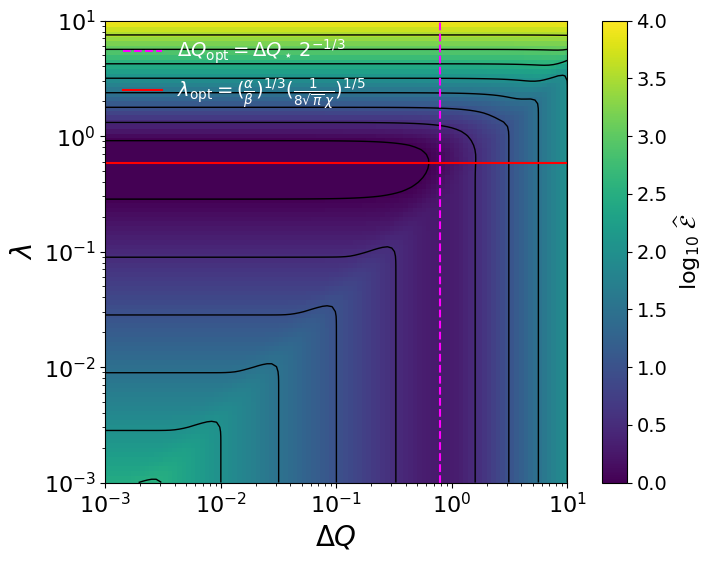

In [51]:
# ----------------------------
# Parameters and grids (PHYSICAL AXES)
# ----------------------------
# Set alpha, beta, chi per your data (chi used for small-ρ line only)
alpha = 1.0
beta  = 1.0
chi   = 1.0

# Characteristic bin width: ΔQ_* = (α/β)^{1/3}
DQ_star = (alpha / beta) ** (1.0/3.0)

# Physical grids
DQ_vals   = np.logspace(-3, 1, 101)   # ΔQ
lam_vals  = np.logspace(-3, 1, 101)   # λ

# Mesh and derived reduced vars
X_DQ, Y_lam   = np.meshgrid(DQ_vals, lam_vals)  # X=ΔQ, Y=λ
rho_grid      = X_DQ / Y_lam                    # ρ = ΔQ / λ
dQhat_grid    = X_DQ / DQ_star                  # \widehat{ΔQ}

# ----------------------------
# Evaluate reduced error surface \widehat{\mathcal{E}}(\widehat{ΔQ}, ρ)
# ----------------------------
Zhat = np.empty_like(rho_grid, dtype=float)
for i in range(rho_grid.shape[0]):
    for j in range(rho_grid.shape[1]):
        rho   = rho_grid[i, j]
        dQhat = dQhat_grid[i, j]
        G     = G_of_rho(rho)
        mu2   = mu2_of_rho(rho, dQhat)   # see note above
        val   = G / dQhat + dQhat**2 + (mu2**2)   # \widehat{\mathcal{E}}
        Zhat[i, j] = max(val, 1e-10)             # guard for log10

# ----------------------------
# Asymptotic optimal lines in (ΔQ, λ)
# ----------------------------
# Large-ρ: \widehat{ΔQ}_{opt} = 2^{-1/3}  ⇒  ΔQ_{opt} = ΔQ_*·2^{-1/3} (vertical)
DQ_opt_large = DQ_star * (2.0 ** (-1.0/3.0))

# Small-ρ: \widehat{ΔQ}_{opt} ~ ρ·(8√π χ)^{-1/5}
#          with ρ = ΔQ/λ ⇒ λ_{opt} = ΔQ_*·(8√π χ)^{-1/5} (horizontal)
lam_opt_small = DQ_star * (1.0 / (8.0 * np.sqrt(np.pi) * chi)) ** (1.0/5.0)

# ----------------------------
# Plot (labels, fonts, sizes, colors as in your code)
# ----------------------------
fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)

ax = fig.add_subplot(gs[0])
CSf = ax.pcolormesh(X_DQ, Y_lam, np.log10(Zhat), vmax=4, vmin=0, shading='nearest')
CS = ax.contour(X_DQ, Y_lam, np.log10(Zhat), levels=np.linspace(0, 4, 9), linewidths=1, colors='k')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\Delta Q$', fontsize=20)
ax.set_ylabel(r'$\lambda$', fontsize=20)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)

# Overlay asymptotic lines with your colors/styles
# Large-ρ vertical line (magenta)
ax.axvline(DQ_opt_large, linestyle='--', linewidth=1.5,
           label=r'$\Delta Q_{\mathrm{opt}}=\Delta Q_\star\,2^{-1/3}$', color="#FF00FF")
# Small-ρ horizontal line (red)
ax.axhline(lam_opt_small, linestyle='-', linewidth=1.5,
           label=r'$\lambda_{\mathrm{opt}}=(\frac{\alpha}{\beta})^{1/3}(\frac{1}{8\sqrt{\pi}\,\chi})^{1/5}$', color='r')

ax.legend(fontsize=14, frameon=False, labelcolor='w')

ax.set_xlim(DQ_vals[0], DQ_vals[-1])
ax.set_ylim(lam_vals[0], lam_vals[-1])

# Colorbar (same label/font sizes)
cax = fig.add_subplot(gs[1])
cbar = plt.colorbar(CSf, cax=cax)
cbar.set_label(r'$\log_{10}\,\widehat{\mathcal{E}}\,$', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1287670/3977463750.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


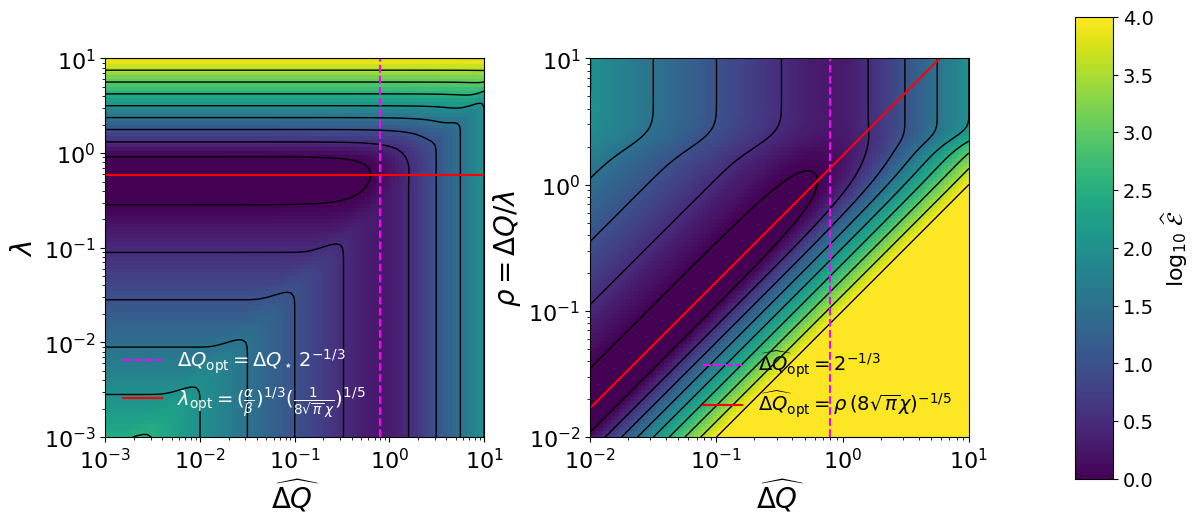

In [72]:
fig = plt.figure(figsize=(13, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[10, 10, 1], wspace=0.4)
ax = fig.add_subplot(gs[0])
# ----------------------------
CSf = ax.pcolormesh(X_DQ, Y_lam, np.log10(Zhat), vmax=4, vmin=0, shading='nearest')
CS = ax.contour(X_DQ, Y_lam, np.log10(Zhat), levels=np.linspace(0, 4, 9), linewidths=1, colors='k')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\widehat{\Delta Q}$', fontsize=20)
ax.set_ylabel(r'$\lambda$', fontsize=20)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)

# Overlay asymptotic lines with your colors/styles
# Large-ρ vertical line (magenta)
ax.axvline(DQ_opt_large, linestyle='--', linewidth=1.5,
           label=r'$\Delta Q_{\mathrm{opt}}=\Delta Q_\star\,2^{-1/3}$', color="#FF00FF")
# Small-ρ horizontal line (red)
ax.axhline(lam_opt_small, linestyle='-', linewidth=1.5,
           label=r'$\lambda_{\mathrm{opt}}=(\frac{\alpha}{\beta})^{1/3}(\frac{1}{8\sqrt{\pi}\,\chi})^{1/5}$', color='r')

ax.legend(fontsize=14, frameon=False, labelcolor='w', loc='lower left')

ax.set_xlim(DQ_vals[0], DQ_vals[-1])
ax.set_ylim(lam_vals[0], lam_vals[-1])

# # Colorbar (same label/font sizes)
# cax = fig.add_subplot(gs[1])
# cbar = plt.colorbar(CSf, cax=cax)
# cbar.set_label(r'$\log_{10}\,\widehat{\mathcal{E}}\,$', fontsize=16)
# cbar.ax.tick_params(labelsize=14)

ax = fig.add_subplot(gs[1])
# ----------------------------
CS = ax.contour(X, Y, np.log10(Z), levels=np.linspace(0, 4, 9), linewidths=1, colors='k')
CSf = ax.pcolormesh(X, Y, np.log10(Z), vmax=4, vmin=0, shading='nearest')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\widehat{\Delta Q}$', fontsize=20)
ax.set_ylabel(r'$\rho=\Delta Q/\lambda$', fontsize=20)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)

# Overlay asymptotic lines (no explicit colors set)
# Large-ρ vertical line
ax.axvline(dQ_opt_large, linestyle='--', linewidth=1.5, label=r'$\widehat{\Delta Q}_{\mathrm{opt}}=2^{-1/3}$', color="#FF00FF")
# Small-ρ curve
ax.plot(dQ_opt_small_curve, rho_vals, linestyle='-', linewidth=1.5,
        label=r'$\widehat{\Delta Q}_{\mathrm{opt}}=\rho\,(8\sqrt{\pi}\chi)^{-1/5}$', color='r')

ax.legend(fontsize=14, frameon=False, labelcolor='k')

ax.set_xlim(dQ_vals[0], dQ_vals[-1])
ax.set_ylim(rho_vals[0], rho_vals[-1])

# Colorbar
cax = fig.add_subplot(gs[2])
cbar = plt.colorbar(CSf, cax=cax)
cbar.set_label(r'$\log_{10}\,\widehat{\mathcal{E}}\,$', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()